## Imports

In [2]:
import numpy as np 
import pandas as pd
import regex as re
import unicodedata as ud
import nltk
from nltk.stem.isri import ISRIStemmer
from nltk.tokenize import wordpunct_tokenize
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
import multiprocessing
from tqdm import tqdm
from sklearn import utils
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import numpy as np
import arabic_reshaper as ar
from bidi.algorithm import get_display
import matplotlib.pyplot as plt

## Movies Datasets

In [271]:
forties_df = pd.read_csv('1940s_data/1940s_movies.csv')
fifties_df = pd.read_csv('1950s_data/1950s_movies.csv')
sixties_df = pd.read_csv('1960s_data/1960s_movies.csv')
seventies_df = pd.read_csv('1970s_data/1970s_movies.csv')

#### EDA functions

In [4]:
def describe_dataframe(df):
    
    for column in df.columns:
        
        print('Column Name: ', u'\u202B' + str(column) + u'\u202C')
        print(df[column].describe())
        print('\n'+'-'*20)

#### Cleansing functions

In [5]:
def change_empty_entries_to_None(df):
    for column in df.columns:
        for row_index in range(df.shape[0]):
            if '??' in str(df.loc[row_index, column]) or \
            df.loc[row_index, column] == 'nan' or \
            df.loc[row_index, column] == '-' or \
            type(df.loc[row_index, column]) == float:
                    df.loc[row_index, column] = None
    return df

In [6]:
def unify_date_format(df):
    for row in range(df.shape[0]):
        
        release_day = df.iloc[row, 15]
        if len(str(release_day)) == 4:
            df.iloc[row,17] = release_day
            df.iloc[row,16] = 'يناير'

    return df

In [7]:
def expand_release_date(df):
    # line continuation operators  '\' used for cleaner code
    df[['اليوم', 'الشهر', 'السنة']] = \
    df['تاريخ العرض'].str.split(' ', expand = True)
    
    return df

In [8]:
def parse_line(line_to_parse):
    
            parsed_values = line_to_parse.split('||')
            movie_name_date = parsed_values[0].strip(')').split('(')
            
            name = movie_name_date[0]
            year = movie_name_date[1]
            df_feature = parsed_values[1]
            
            return name, year, df_feature

In [9]:
def add_scraped_features(df, file_path, column_name):
    
    with open(file_path, 'r') as filehandle:
        
        for line in filehandle:
            
            current_line = line[:-1]
            name, year, df_feature = parse_line(current_line)
            if(not(df_feature == '') \
              or (str(df_feature) == 'nan')):
                df.loc[(df['اسم الفيلم'] == name) \
                     & (df['السنة'] == year), column_name] = df_feature     
    return df

In [10]:
def filter_foregin_movies(df, file_path):
    
    with open(file_path, 'r') as filehandle:
            
        for line in filehandle:
            
            current_line = line[:-1]
            name, year, country = parse_line(current_line)
           
            if(not(('مصر') in country)):   
                movie_index = df.loc[(df['اسم الفيلم'] == name) \
                                     & (df['السنة'] == year)].index
                df.drop(inplace = True, index = movie_index)
    return df

In [12]:
def get_null_percentage(df):
    
    total_count = df.shape[0]
    for column in df.columns:
    
        missing_count = df[column].isna().sum()
        missing_percentage = (missing_count/total_count)*100
        print('>> ' + u'\u202B' + column + ': '+ str(round(missing_percentage)) + '%')

In [13]:
actor_gender_dictionary = pd.read_csv('actor_gender_dictionary.csv')

In [14]:
actor_gender_dictionary.sample()

,Unnamed: 0,name,gender
785,600,سهير الباروني,ذكر


In [15]:
actor_gender_dictionary.drop(columns = ['Unnamed: 0'], inplace= True)

In [16]:
actor_gender_dictionary.sample()

,name,gender
1323,خالد قرانوح,ذكر


In [310]:
def seperate_cast_by_gender(movies_df, gender_df = actor_gender_dictionary):
    
    movies_df['ممثلات'] = None
    movies_df['ممثلون'] = None
    unassigned_rows = []
    for row_index in range(movies_df.shape[0]):
        
        cast = movies_df.loc[row_index, 'تمثيل']
        try:
            actresses = []
            actors = []
            if( ',' in cast):
                
                cast = cast.split(',')
                
                for actor in cast:

                    gender = gender_df.loc[gender_df['name'] == actor]['gender']

                    if(gender.values == 'ذكر'):
                        actors.append(actor)

                    if(gender.values == 'أنثى'):
                        actresses.append(actor)

                movies_df.at[row_index, 'ممثلات'] = actresses
                movies_df.at[row_index, 'ممثلون'] = actors
                        
        except:
                unassigned_rows.append(row_index)
                
        finally:
                movies_df.at[row_index, 'ممثلات'] = actresses
                movies_df.at[row_index, 'ممثلون'] = actors
    return movies_df, unassigned_rows 

In [422]:
def split_string(string_to_split):
    crew_names = []
    try:
        for word in string_to_split.split(','):
            crew_names.append(word)
    finally:
        return crew_names

In [417]:
def seperate_authors_directors(movies_df):
    
    for row_index in range(movies_df.shape[0]):
        authors = movies_df.loc[row_index, 'تأليف']
        directors = movies_df.loc[row_index, 'إخراج']
        
        authors_list = split_string(authors)
        directors_list = split_string(directors)
        
        movies_df.at[row_index, 'تأليف'] = authors_list
        movies_df.at[row_index, 'إخراج'] = directors_list
        
    return movies_df

### *_1940s Movies_*

#### EDA

In [20]:
describe_dataframe(forties_df)

Column Name:  ‫اسم الفيلم‬
count             331
unique            330
top       خاتم سليمان
freq                2
Name: اسم الفيلم, dtype: object

--------------------
Column Name:  ‫تاريخ العرض‬
count      331
unique     216
top       1946
freq        24
Name: تاريخ العرض, dtype: object

--------------------
Column Name:  ‫التصنيف‬
count       127
unique        9
top       ??ا??
freq         46
Name: التصنيف, dtype: object

--------------------
Column Name:  ‫المدة‬
count    331.000000
mean     106.399698
std       11.097976
min       70.000000
25%      100.000000
50%      105.000000
75%      110.000000
max      152.000000
Name: المدة, dtype: float64

--------------------
Column Name:  ‫ملخص‬
count                                                   316
unique                                                  316
top       يقع وجدى فى حيرة من أمر البنات الثلاث التى يلت...
freq                                                      1
Name: ملخص, dtype: object

--------------------
Column N

In [21]:
forties_df.loc[forties_df['اسم الفيلم'] == 'خاتم سليمان']

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
174,خاتم سليمان,1946,NaN,103.2,NaN,أبو بثينة,أمينة شريف,أفلام حرب,NaN,NaN,NaN,NaN,NaN,فؤاد شبل,NaN
227,خاتم سليمان,1947,ا????ا??,117.0,تناول الفيلم في إطار من الخيال، قصة المعلم بيو...,"حسن رمزي,السيد زيادة","ليلى مراد,يحيى شاهين,زكي رستم,نيللي مظلوم,ثريا...",أفلام النصر (محمد حسن رمزي وشركاه),"مصطفى حسن,وحيد فريد","ألبير نجيب,وفيقة أبو جبل",حبيب خوري,قاسم وجدي,"حسين السيد,السيد زيادة,رياض السنباطي,محمد القص...","حسن رمزي,ألبير نجيب,عبدالرحمن شريف",NaN


In [22]:
forties_df.dtypes

اسم الفيلم      object
تاريخ العرض     object
التصنيف         object
المدة          float64
ملخص            object
تأليف           object
تمثيل           object
إنتاج           object
تصوير           object
مونتاج          object
ديكور           object
ملابس           object
موسيقى          object
إخراج           object
توزيع           object
dtype: object

In [23]:
forties_df['التصنيف'].value_counts()

??ا??       46
???????     26
??????      25
ا????ا??    16
?????        7
?????ا?      2
????         2
تاريخي       2
???          1
Name: التصنيف, dtype: int64

In [24]:
get_null_percentage(forties_df)

>> ‫اسم الفيلم: 0%
>> ‫تاريخ العرض: 0%
>> ‫التصنيف: 62%
>> ‫المدة: 0%
>> ‫ملخص: 5%
>> ‫تأليف: 7%
>> ‫تمثيل: 1%
>> ‫إنتاج: 26%
>> ‫تصوير: 15%
>> ‫مونتاج: 28%
>> ‫ديكور: 39%
>> ‫ملابس: 94%
>> ‫موسيقى: 35%
>> ‫إخراج: 6%
>> ‫توزيع: 49%


#### Cleansing

In [25]:
forties_df = change_empty_entries_to_None(forties_df)

In [26]:
forties_df['التصنيف'].value_counts()

تاريخي    2
Name: التصنيف, dtype: int64

In [27]:
expanded_date_40s = forties_df.copy(deep = True)

In [28]:
expanded_date_40s = expand_release_date(forties_df)
expanded_date_40s = unify_date_format(expanded_date_40s)

In [29]:
expanded_date_40s = expanded_date_40s.drop(columns=['تاريخ العرض','اليوم'])
expanded_date_40s['التقييم'] = None

_**Filling Missing Values**_

* **Add Webscraped Ratings**

In [30]:
foreigns_filtered_40s  = expanded_date_40s.copy(deep = True)

In [31]:
foreigns_filtered_40s = filter_foregin_movies(expanded_date_40s \
                                                , '1940s_data/countries_1940s.txt')

In [32]:
genre_added_40s = foreigns_filtered_40s.copy(deep = True)

In [33]:
genre_added_40s = add_scraped_features(foreigns_filtered_40s \
                                          , '1940s_data/1940s_genres.txt' \
                                         , 'التصنيف')

In [34]:
genre_added_40s['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                75
ﻛﻮﻣﻴﺪﻱ               23
موسيقي / استعراضي    13
ﺭﻭﻣﺎﻧﺴﻲ              12
ﻋﺎﺋﻠﻲ                 2
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          2
ﺟﺮﻳﻤﺔ                 2
ﺣﺮﺏ                   1
ﺧﻴﺎﻝ                  1
ﻣﻐﺎﻣﺮاﺕ               1
Name: التصنيف, dtype: int64

In [35]:
ratings_added_40s = genre_added_40s.copy(deep = True)

In [36]:
ratings_added_40s = add_scraped_features(genre_added_40s \
                                          , '1940s_data/1940s_ratings.txt' \
                                         , 'التقييم')

In [37]:
synopsis_added_40s = ratings_added_40s.copy(deep = True)

In [38]:
synopsis_added_40s = add_scraped_features(ratings_added_40s \
                                          , '1940s_data/1940s_synopses.txt' \
                                         , 'ملخص')

In [39]:
synopsis_added_40s = synopsis_added_40s.reset_index(drop=True)

In [40]:
synopsis_added_40s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم
55,بنت الشيخ,ﻣﻐﺎﻣﺮاﺕ,110.0,يقرر الشاب التقدم للفتاة التي يحبها من القبيلة...,أحمد كامل مرسي,"أمينة نور الدين,يحيى شاهين,هاجر حمدي,عباس فارس...",علي الجابري,أحمد خورشيد,جلال مصطفى,None,None,إبراهيم حجايج,أحمد كامل مرسي,None,يناير,1943,4.6


In [41]:
get_null_percentage(synopsis_added_40s)

>> ‫اسم الفيلم: 0%
>> ‫التصنيف: 60%
>> ‫المدة: 0%
>> ‫ملخص: 2%
>> ‫تأليف: 7%
>> ‫تمثيل: 1%
>> ‫إنتاج: 26%
>> ‫تصوير: 14%
>> ‫مونتاج: 28%
>> ‫ديكور: 39%
>> ‫ملابس: 94%
>> ‫موسيقى: 35%
>> ‫إخراج: 6%
>> ‫توزيع: 48%
>> ‫الشهر: 0%
>> ‫السنة: 0%
>> ‫التقييم: 5%


In [42]:
synopsis_added_40s['التقييم'] = synopsis_added_40s['التقييم'].astype(float)

In [43]:
cast_seperated_40s,_ = seperate_cast_by_gender(synopsis_added_40s)

/Users/karefsn/Development/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/karefsn/Development/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [44]:
cast_seperated_40s.drop(inplace = True, columns = ['تمثيل'])

In [45]:
cast_seperated_40s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم,ممثلات,ممثلون
135,نجف,None,105.0,يعمل الشيخ عبدالمقصود على تربية حامد ابن أخيه ...,"عبدالرحمن الخميسي,كامل الحفناوي","أفلام التعاون,فؤاد يوسف","يوسف حافظ,عبدالعزيز فهمي,فرانسوا فاراكاش","أحمد إسماعيل,سيد حسين,فيوليت","يحيى الشافعى,كامل الحفناوي,حسن الشوربجى",None,"حسين السيد,جليل البنداري,محمد أمين","كامل الحفناوي,عبدالعليم خطاب",None,مايو,1946,5.0,"[تحية كاريوكا, زوزو ماضي, لطيفة أمين, فتحية علي]","[محمد أمين, عبدالسروجى, محمد الديب, محمد إدريس..."


In [46]:
cast_seperated_40s.drop(columns = ['توزيع', 'ملابس', 'ديكور', 'مونتاج', \
                         'تصوير', 'موسيقى', 'إنتاج'], inplace = True)

In [47]:
movies_40s_df = cast_seperated_40s[['اسم الفيلم', 'الشهر', 'السنة', 'التصنيف',\
                                    'التقييم', 'المدة', 'ملخص', 'ممثلات', 'ممثلون',
                                    'تأليف', 'إخراج']]

In [48]:
movies_40s_df.sample()

,اسم الفيلم,الشهر,السنة,التصنيف,التقييم,المدة,ملخص,ممثلات,ممثلون,تأليف,إخراج
152,عدو المرأة,ديسمبر,1946,ﺩﺭاﻣﺎ,5.1,115.0,رؤوف كاتب مشهور كبير السن معروفٌ بمواقفه ضد ال...,"[صباح, سامية فهمي, نبوية مصطفى, كوكب صادق]","[محمد فوزي, زكي رستم, رياض القصبجي, عبدالمجيد ...","محمد حسن كامل,بديع خيري","عبدالفتاح حسن,توفيق نبيه,أنور حمودة,عبدالرحمن ..."


### *_1950s Movies_*

_**EDA**_

In [49]:
fifties_df.sample(10)

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
265,حدث ذات ليلة,18 اكتوبر 1954,??ا??,112.0,تتزوج فتاة فقيرة من شاب ثري ، وذلك رغم معارضة ...,"فتحي أبو الفضل,هنري بركات","هدى سلطان,محسن سرحان,كمال الشناوي,عايدة كامل,ع...","إبراهيم مصطفى,أرمان بوهالوفيتش","كليليو (ك. ستشفللي),محمود بكر","فتحى قاسم,مارسيل صالح,فريدا","عباس حلمي,حسن الشوربجى,عبدالمنعم على",NaN,"مأمون الشناوي,محمد القصبجي,أحمد صدقي,محمود الشريف","هنري بركات,ريمون نصور,أحمد فاروق",منتخبات بهنا فيلم
159,الحب بهدلة,1952,ا????ا??,111.1,ثلاث فتيات يعملن في أحد الملاهي الليلية، على ع...,"صلاح أبو سيف,جمال حمدي (غصين محمود حمدي)","محمد أمين,هدى شمس الدين,إسماعيل يس,ثريا حلمي,ل...",NaN,NaN,NaN,NaN,NaN,NaN,صلاح أبو سيف,NaN
120,قليل البخت,12 مايو 1952,??ا??,110.0,تدور احداث القصة حول (حسين) ابن الشيخ (عبدالرح...,زهير بكير,"شادية,كمال الشناوي,رضوان,زمردة,إسماعيل يس,محمو...","أفلام أميّة,ستوديو الأهرام (ستوديوهات الأهرام)...","فيرى فاركاش (فرانسوا فاركاش),زكريا منصور,ضياء ...","محمد عباس,مارسيل صالح","حبيب خوري,روبرت شارفنبرج,ستوديو الأهرام (ستودي...",NaN,"إبراهيم حسين,عزت الجاهلي,إسماعيل نظمى,أحمد صبر...","محمد عبدالجواد,فهمي عبدالجواد",أفرا موسى
373,أين عمري,1956,??ا??,108.1,تدور قصة الفيلم حول التلميذة “علية” التي تسعي ...,NaN,"ماجدة,زكي رستم,يحيى شاهين,ميمي شكيب,أحمد رمزي,...",ماجدة,NaN,NaN,NaN,NaN,NaN,أحمد ضياء الدين,NaN
61,حبيبتى سوسو,5 ابريل 1951,??????,110.0,سوسو مخطوبة لثرى لا تحبه وبالصدفة هناك مطربة ا...,"أبو السعود الإبياري,نيازي مصطفى","ليلى فوزي,محسن سرحان,سليمان نجيب,ميمي شكيب,إسم...",نحّاس فيلم,محمود نصر,جلال مصطفى,NaN,NaN,"زكريا أحمد,علي فراج,عالية,سوسن فؤاد",نيازي مصطفى,نحّاس فيلم
6,قمر 14,3 ابريل 1950,???????,88.0,تدور أحداث الفيلم حول محسن (محمود ذو الفقار) ا...,عبدالفتاح السيد,"كاميليا,محمود ذو الفقار,حسن فايق,فردوس محمد,ال...",ستوديو مصر,كليليو (ك. ستشفللي),جلال مصطفى,"نجيب خوري,أنطوان بوليزويس",NaN,NaN,"نيازي مصطفى,محمد جلال",ستوديو مصر
115,شمشون ولبلب (عنتر ولبلب),17 ابريل 1952,??????,117.0,تدور أحداث القصة حول (لبلب)، الذي يعيش في هدوء...,"بديع خيري,ريمون قربة,سيف الدين شوكت","سراج منير,محمود شكوكو,عبدالوارث عسر,سعاد أحمد,...","جبرائيل نحاس,رمسيس نجيب",محمد عز العرب,ريمون قربة,ستوديو نحاس (النيل),NaN,"فتحي قورة,محمد الكحلاوي","سيف الدين شوكت,لطفى نور الدين",نحّاس فيلم
318,ليالي الحب,15 اكتوبر 1955,ا????ا??,125.0,أحمد ممتاز موظف بسيط ابتكر نوعاً من القماش لا ...,"إسماعيل الحبروك,أبو السعود الإبياري,حلمي رفلة,...","عبدالحليم حافظ,آمال فريد,عبدالسلام النابلسي,سر...",أفلام حلمى رفلة,"محمود نصر,حسن البحيري,جودة عبدالجواد","حسن حلمي (حسنوف),زينب عويس","أنطوان بوليزويس,نجيب خوري",NaN,"أندريا رايدر (أندريه رايدر),فتحي قورة,صالح جود...","حلمي رفلة,عدلي خليل,منير رفله",الشرق للتوزيع
313,رنة الخلخال,25 يوليو 1955,??ا??,120.0,فتاة ضالة لا ملجا لها ولا معين بعدوفاة ابيها. ...,"أمين يوسف غراب,محمود ذو الفقار","مريم فخر الدين,شكري سرحان,نجمة إبراهيم,عبدالوا...","أفلام مريم فخر الدين,محمد حجاج,مريم فخر الدين","ضياء الدين المهدي,عبدالمنعم بهنسي,برونو سالفي","ألبير نجيب,كمال فهمي","عبدالمنعم على,عباس حلمي,ستوديو الأهرام (ستوديو...",محمد مرعى,"سيد مصطفى,أحمد صبرة,عبدالحليم نويرة,فتحي قورة,...","محمود ذو الفقار,محمود فريد",NaN
353,شياطين الجو,2 ابريل 1956,NaN,100.0,فرغلى وعواد وأحمد ثلاثة جنود ، يتقابلون لأول م...,"السيد بدير,عبدالحميد جودة السحار,وجيه أباظة,ني...","شكري سرحان,أحمد رمزي,آمال فريد,عبدالسلام الناب...",NaN,روبير طمبا,انجا وميلا,"ستوديو الأهرام (ستوديوهات الأهرام),أنطوان بولي...",NaN,محمد فوزي,"نيازي مصطفى,شريف حمودة",NaN


In [50]:
describe_dataframe(fifties_df)

Column Name:  ‫اسم الفيلم‬
count              534
unique             533
top       هل أقتل زوجى
freq                 2
Name: اسم الفيلم, dtype: object

--------------------
Column Name:  ‫تاريخ العرض‬
count      534
unique     368
top       1953
freq        14
Name: تاريخ العرض, dtype: object

--------------------
Column Name:  ‫التصنيف‬
count       383
unique       11
top       ??ا??
freq        138
Name: التصنيف, dtype: object

--------------------
Column Name:  ‫المدة‬
count    534.000000
mean     108.119663
std       13.207141
min       53.000000
25%      100.000000
50%      108.350000
75%      115.000000
max      170.000000
Name: المدة, dtype: float64

--------------------
Column Name:  ‫ملخص‬
count                                                   522
unique                                                  522
top       تدور أحداث الفيلم حول ثلاث أشخاص، هم ضابط الشر...
freq                                                      1
Name: ملخص, dtype: object

--------------------
Colu

In [51]:
fifties_df = change_empty_entries_to_None(fifties_df)

In [52]:
fifties_df['التصنيف'].value_counts()

تاريخي    10
Name: التصنيف, dtype: int64

_**Cleansing**_

In [53]:
fifties_df[fifties_df.duplicated(subset = ['اسم الفيلم'])]

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
441,هل أقتل زوجى,5 مايو 1958,None,87.0,تبدأ أحداث الفيلم بجو هادئ مرح فى أسرة مكونة م...,محمد كامل حسن المحامي,"محسن سرحان,سميرة أحمد,توفيق الدقن,سهير البابلي...","وليم رزق,حسن موافى,فرغل البارودي,حسام الدين مصطفى","البير رياض,كليليو (ك. ستشفللي)",حسن حلمي (حسنوف),"أنطوان بوليزويس,عبدالمنعم على",None,None,"حسام الدين مصطفى,سيمون صالح,مصطفى سمهان,إبراهي...",None


In [54]:
fifties_df.loc[fifties_df['اسم الفيلم'] == 'هل أقتل زوجى']

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
378,هل أقتل زوجى,1956,None,108.1,None,None,None,None,None,None,None,None,None,None,None
441,هل أقتل زوجى,5 مايو 1958,None,87.0,تبدأ أحداث الفيلم بجو هادئ مرح فى أسرة مكونة م...,محمد كامل حسن المحامي,"محسن سرحان,سميرة أحمد,توفيق الدقن,سهير البابلي...","وليم رزق,حسن موافى,فرغل البارودي,حسام الدين مصطفى","البير رياض,كليليو (ك. ستشفللي)",حسن حلمي (حسنوف),"أنطوان بوليزويس,عبدالمنعم على",None,None,"حسام الدين مصطفى,سيمون صالح,مصطفى سمهان,إبراهي...",None


In [55]:
expanded_date_50s = fifties_df.copy(deep = True)

In [56]:
expanded_date_50s = expand_release_date(fifties_df)
expanded_date_50s = unify_date_format(expanded_date_50s)

In [57]:
expanded_date_50s.drop(columns=['تاريخ العرض','اليوم'], inplace = True)
expanded_date_50s['التقييم'] = None

_**Filling Missing Values**_

* **Add Webscraped Ratings**

In [58]:
foreign_filtered_50s = expanded_date_50s.copy(deep = True)

In [59]:
foreign_filtered_50s = filter_foregin_movies(expanded_date_50s
                                               , '1950s_data/countries_1950s.txt')

In [60]:
ratings_added_50s = foreign_filtered_50s.copy(deep = True)

In [61]:
ratings_added_50s = add_scraped_features(foreign_filtered_50s \
                                           , '1950s_data/1950s_ratings.txt'
                                           , 'التقييم')

In [62]:
genres_added_50s = ratings_added_50s.copy(deep = True)

In [63]:
genres_added_50s = add_scraped_features(ratings_added_50s \
                                           , '1950s_data/1950s_genres.txt'
                                           , 'التصنيف')

In [64]:
genres_added_50s.reset_index(drop = True, inplace = True)


In [65]:
synopsis_added_50s = genres_added_50s.copy(deep = True)

In [66]:
synopsis_added_50s = add_scraped_features(genres_added_50s \
                                          , '1950s_data/1950s_synopses.txt' \
                                         , 'ملخص')

In [68]:
synopsis_added_50s['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                192
ﻛﻮﻣﻴﺪﻱ                60
ﺭﻭﻣﺎﻧﺴﻲ               44
موسيقي / استعراضي     31
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          14
تاريخي                 9
ﺟﺮﻳﻤﺔ                  8
ﺣﺮﻛﺔ                   6
ﻋﺎﺋﻠﻲ                  3
ﺧﻴﺎﻝ ﻋﻠﻤﻲ              3
ﺣﺮﺏ                    2
ﻏﻤﻮﺽ                   2
ﺭﻋﺐ                    1
ﺧﻴﺎﻝ                   1
ﻣﻐﺎﻣﺮاﺕ                1
Name: التصنيف, dtype: int64

* "ﺧﻴﺎﻝ ﻋﻠﻤﻲ" and "ﺧﻴﺎﻝ", same genre but named differently!

In [74]:
synopsis_added_50s.loc[synopsis_added_50s['التصنيف'] == 'ﺧﻴﺎﻝ ﻋﻠﻤﻲ', 'التصنيف'] = 'ﺧﻴﺎﻝ'

In [75]:
synopsis_added_50s['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                192
ﻛﻮﻣﻴﺪﻱ                60
ﺭﻭﻣﺎﻧﺴﻲ               44
موسيقي / استعراضي     31
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          14
تاريخي                 9
ﺟﺮﻳﻤﺔ                  8
ﺣﺮﻛﺔ                   6
ﺧﻴﺎﻝ                   4
ﻋﺎﺋﻠﻲ                  3
ﺣﺮﺏ                    2
ﻏﻤﻮﺽ                   2
ﺭﻋﺐ                    1
ﻣﻐﺎﻣﺮاﺕ                1
Name: التصنيف, dtype: int64

In [76]:
synopsis_added_50s = synopsis_added_50s.reset_index(drop=True)

In [77]:
synopsis_added_50s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم
108,غضب الوالدين,ﺩﺭاﻣﺎ,120.0,ينجح أحد الفراشين العاملين بإحدى الشركات في ال...,"حسن الإمام,حسن عبدالوهاب,محمد مصطفى سامي","شادية,محسن سرحان,أمينة رزق,حسين رياض,سميحة توف...","إبراهيم مصطفى,أرمان بوهالوفيتش","محمود فهمي,ألفيزى اورفانيللى,جمال أحمد","إحسان فرغل,مارسيل صالح","عباس حلمي,عبدالمنعم على,عبدالمنعم شكري",None,"محمود الشريف,فتحي قورة,إبراهيم حجايج","حسن الإمام,عبدالرحمن شريف,حسن نعمة الله","منتخبات بهنا فيلم,أفلام مصر العربية (واصف فايز)",مارس,1952,6.9


In [78]:
get_null_percentage(synopsis_added_50s)

>> ‫اسم الفيلم: 0%
>> ‫التصنيف: 29%
>> ‫المدة: 0%
>> ‫ملخص: 1%
>> ‫تأليف: 3%
>> ‫تمثيل: 0%
>> ‫إنتاج: 12%
>> ‫تصوير: 9%
>> ‫مونتاج: 13%
>> ‫ديكور: 14%
>> ‫ملابس: 84%
>> ‫موسيقى: 30%
>> ‫إخراج: 1%
>> ‫توزيع: 54%
>> ‫الشهر: 0%
>> ‫السنة: 0%
>> ‫التقييم: 6%


In [79]:
synopsis_added_50s['التقييم'] = synopsis_added_50s['التقييم'].astype(float)

In [80]:
synopsis_added_50s = synopsis_added_50s.reset_index(drop = True)

In [81]:
cast_seperated_50s,_ = seperate_cast_by_gender(synopsis_added_50s)

/Users/karefsn/Development/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/karefsn/Development/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [82]:
cast_seperated_50s.drop(inplace = True, columns = ['تمثيل'])

In [83]:
cast_seperated_50s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم,ممثلات,ممثلون
280,الأستاذ شرف,None,110.5,ناظر مدرسة أهلية، ينجح التلاميذ بها طبقًا للما...,"أبو السعود الإبياري,كامل التلمساني",None,كليليو (ك. ستشفللي),None,None,None,None,كامل التلمساني,None,يناير,1954,4.7,"[سميرة أحمد, جواهر, وداد حمدي]","[أنور وجدي, محمود المليجي, عبدالغني قمر, عبدال..."


In [84]:
cast_seperated_50s.drop(columns = ['توزيع', 'ملابس', 'ديكور', 'مونتاج', \
                         'تصوير', 'موسيقى', 'إنتاج'], inplace = True)

In [85]:
movies_50s_df = cast_seperated_50s[['اسم الفيلم', 'الشهر', 'السنة', 'التصنيف',\
                                    'التقييم', 'المدة', 'ملخص', 'ممثلات', 'ممثلون',
                                    'تأليف', 'إخراج']]

In [86]:
movies_50s_df.sample()

,اسم الفيلم,الشهر,السنة,التصنيف,التقييم,المدة,ملخص,ممثلات,ممثلون,تأليف,إخراج
468,الحب الصامت,يناير,1958,None,4.7,109.4,(صفوت) مهندس يمتلك شركة مقاولات ومتزوج من (سمي...,"[مريم فخر الدين, هند رستم, منيرة سنبل, فردوس م...","[يحيى شاهين, فاروق عجرمة, زكي إبراهيم, أحمد لو...",حسين حلمي المهندس,سيف الدين شوكت


### *_1960s Movies_*

_**EDA**_

In [87]:
sixties_df.sample(5)

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
150,الرجل الثعلب,14 مايو 1962,NaN,95.0,فريد ينتمى لعائلة كبيرة لكنه فشل فى دراسته وان...,"إسماعيل القاضي,أنور قزمان","فريد شوقي,ريري,أمينة رزق,كريمان,فايزة فؤاد,محم...",دينار فيلم,على حسن,حسين عفيفي,"الاستديوهات العربية الهرم,أنطوان بوليزويس,نجيب...",NaN,NaN,نجدي حافظ,NaN
266,العائلة الكريمة,21 فبراير 1964,NaN,85.0,(ست أبوها) فتاة تسكن مع أمها فى أحد الأحياء ال...,"بديع خيري,نجيب الريحاني,عبدالحي أديب,بهجت قمر","هدى سلطان,فريد شوقي,ماري منيب,عادل أدهم,أحمد خ...","الشركة العامة للإنتاج السينمائي العربي,سعد شنب...","كمال كريم,صلاح كريم","حسين أحمد,محمد الزرقا,كمال فهمي","ماهر عبدالنور,ستوديو نحاس (النيل),حسين الشريف ...",NaN,"ميشيل يوسف,محمد فوزي,فتحي قورة,هدى سلطان","فطين عبدالوهاب,صالح فوزي",دولار فيلم (إسماعيل الكردي وأولاده)
91,رجل في حياتي,21 يونيو 1961,NaN,105.0,يدخل الطالب (حمدي) في صراع مع أحد الصيادين بسب...,"وجيه نجيب,عبدالرحمن الشرقاوي","سامي خالد,توفيق الدقن,إبراهيم نجم,سمير خليل,مح...","وجيه نجيب,افلام سميرة احمد","ألفيزى اورفانيللى,روبير سعد",اميل بحرى,ماهر عبدالنور,NaN,NaN,يوسف شاهين,الشرق للافلام
424,هو.. والنساء,31 اغسطس 1966,اﺳﺘﻌﺮاﺿﻲ,90.0,علوى مخرج مسرحى، يعيش حياة عائلية غير مستقرة، ...,"حسن الإمام,محمد مصطفى سامي","هند رستم,رشدي أباظة,نجوى فؤاد,ناهد شريف,عبدالم...","رزق عبدالحميد,نجوى فؤاد,كمال الحفناوي","البير رياض,غنيم بهنسي,مصطفى حسن","رشيدة عبدالسلام,محمد الزرقا,محيي الدين أحمد,نا...","حلمي عزب,حسين الشريف (حسين شريف),عجمي عبدالرحم...",NaN,"زكريا الحجاوي,خضره محمد خضر,علي إسماعيل","حسن الإمام,صبحى عبدالعزيز",دولار فيلم (إسماعيل الكردي وأولاده)
509,مختار,1968,NaN,109.0,مختار كاتب شاب مشهور، يكتب روايته حول فتاة صغي...,"فريد بوغدير,الصادق بن عيشه","أنيسة لطفي,طارق بن ميلاد,نجاه مبعوج",مؤسسة الدولة للأفلام الثقافية,"لطفى لابو تى,عبداللطيف بن عمار","الصادق بن عيشه,لطيفة بوجمعة",NaN,NaN,NaN,الصادق بن عيشه,NaN


In [88]:
describe_dataframe(sixties_df)

Column Name:  ‫اسم الفيلم‬
count         651
unique        646
top       المتمرد
freq            4
Name: اسم الفيلم, dtype: object

--------------------
Column Name:  ‫تاريخ العرض‬
count      651
unique     324
top       1968
freq        42
Name: تاريخ العرض, dtype: object

--------------------
Column Name:  ‫التصنيف‬
count       359
unique       15
top       ﺩﺭاﻣﺎ
freq        115
Name: التصنيف, dtype: object

--------------------
Column Name:  ‫المدة‬
count    651.000000
mean     102.518280
std       13.958636
min       30.000000
25%       95.000000
50%      101.000000
75%      105.400000
max      195.000000
Name: المدة, dtype: float64

--------------------
Column Name:  ‫ملخص‬
count                                                   560
unique                                                  557
top       عام 1867 فى تونس، فى حى المزاريق، ينهب رجال ال...
freq                                                      4
Name: ملخص, dtype: object

--------------------
Column Name:  ‫تأليف‬
co

In [89]:
sixties_df['التصنيف'].value_counts()

ﺩﺭاﻣﺎ           115
ﺭﻭﻣﺎﻧﺴﻲ          87
ﻛﻮﻣﻴﺪﻱ           76
ﺟﺮﻳﻤﺔ            21
اﺳﺘﻌﺮاﺿﻲ         18
ﺣﺮﻛﺔ             11
تاريخي            9
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ      6
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ        5
ﻏﻤﻮﺽ              3
ﻣﻐﺎﻣﺮاﺕ           3
ﺧﻴﺎﻝ ﻋﻠﻤﻲ         2
ﻗﺼﻴﺮ              1
ﻋﺎﺋﻠﻲ             1
ﻭﺛﺎﺋﻘﻲ            1
Name: التصنيف, dtype: int64

In [90]:
sixties_df.dtypes

اسم الفيلم      object
تاريخ العرض     object
التصنيف         object
المدة          float64
ملخص            object
تأليف           object
تمثيل           object
إنتاج           object
تصوير           object
مونتاج          object
ديكور           object
ملابس           object
موسيقى          object
إخراج           object
توزيع           object
dtype: object

In [131]:
sixties_df[sixties_df.duplicated(subset = ['اسم الفيلم', 'تمثيل'])]

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
518,المتمرد,1968,NaN,100.0,عام 1867 فى تونس، فى حى المزاريق، ينهب رجال ال...,"محمد المرزوقى,عمار الخليفي","سميرة أحمد,طاهر وهب,حطاب الذيب,حسيبة رشدي,الطا...","تونس,عمار الخليفي",عز الدين بن عمار,"فوزية طابع,عمار الخليفي",محمد السهيلى,NaN,NaN,"مصطفى بن إبراهيم,عمار الخليفي",NaN
525,المتمرد,1968,NaN,100.0,عام 1867 فى تونس، فى حى المزاريق، ينهب رجال ال...,"محمد المرزوقى,عمار الخليفي","سميرة أحمد,طاهر وهب,حطاب الذيب,حسيبة رشدي,الطا...","تونس,عمار الخليفي",عز الدين بن عمار,"فوزية طابع,عمار الخليفي",محمد السهيلى,NaN,NaN,"مصطفى بن إبراهيم,عمار الخليفي",NaN
532,المتمرد,1968,NaN,100.0,عام 1867 فى تونس، فى حى المزاريق، ينهب رجال ال...,"محمد المرزوقى,عمار الخليفي","سميرة أحمد,طاهر وهب,حطاب الذيب,حسيبة رشدي,الطا...","تونس,عمار الخليفي",عز الدين بن عمار,"فوزية طابع,عمار الخليفي",محمد السهيلى,NaN,NaN,"مصطفى بن إبراهيم,عمار الخليفي",NaN


_**Cleansing**_

In [132]:
sixties_df = change_empty_entries_to_None(sixties_df)

In [133]:
sixties_df.drop_duplicates(subset = ['اسم الفيلم', 'تمثيل']
                          , inplace= True, keep = 'last')

In [134]:
sixties_df.drop(inplace = True, index = \
               sixties_df.loc[sixties_df['التصنيف'] == 'ﻭﺛﺎﺋﻘﻲ'].index)

In [135]:
sixties_df = sixties_df.reset_index(drop = True)

In [136]:
date_expanded_60s = sixties_df.copy(deep = True)

In [137]:
date_expanded_60s = expand_release_date(sixties_df)
date_expanded_60s = unify_date_format(date_expanded_60s)

In [138]:
date_expanded_60s.drop(columns=['تاريخ العرض', 'اليوم'], inplace= True)

In [139]:
# sixties_df.to_csv('1960s_data/1960s_no_duplicates.csv')

In [140]:
date_expanded_60s['التقييم'] = None

In [141]:
# date_expanded_1960s_df.to_csv('1960s_data/date_expanded_1960s.csv')

In [142]:
date_expanded_60s['التقييم'] = date_expanded_60s['التقييم'].astype(float)

_**Filling Missing Values**_

* **Add Webscraped Ratings**

In [143]:
foreigns_filtered_60s = date_expanded_60s.copy(deep = True)

In [144]:
foreigns_filtered_60s = filter_foregin_movies(date_expanded_60s \
                                                , '1960s_data/1960s_countries.txt')

In [145]:
ratings_added_60s = foreigns_filtered_60s.copy(deep = True)

In [146]:
ratings_added_60s = add_scraped_features(foreigns_filtered_60s \
                                    , '1960s_data/1960s_ratings.txt' \
                                    , 'التقييم')

In [147]:
genre_added_60s = ratings_added_60s.copy(deep = True)

In [148]:
# ratings_added_60s_df.to_csv('1960s_data/ratings_added_df_60s.csv')

In [149]:
genre_added_60s = add_scraped_features(ratings_added_60s \
                                          , '1960s_data/1960s_genres.txt' \
                                         , 'التصنيف')

In [150]:
# genre_added_60s_df.to_csv('1960s_data/genre_added_60s_df.csv')

In [151]:
genre_added_60s['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                171
ﻛﻮﻣﻴﺪﻱ                59
ﺭﻭﻣﺎﻧﺴﻲ               46
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          18
موسيقي / استعراضي     13
ﺟﺮﻳﻤﺔ                 12
ﺣﺮﻛﺔ                   7
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ             4
ﺧﻴﺎﻝ                   4
ﻋﺎﺋﻠﻲ                  4
ﻣﻐﺎﻣﺮاﺕ                4
تاريخي                 2
ﺧﻴﺎﻝ ﻋﻠﻤﻲ              2
ﻏﻤﻮﺽ                   1
ﻗﺼﻴﺮ                   1
Name: التصنيف, dtype: int64

In [169]:
genre_added_60s.loc[genre_added_60s['التصنيف'] == 'ﺧﻴﺎﻝ ﻋﻠﻤﻲ', 'التصنيف'] = 'ﺧﻴﺎﻝ'

In [153]:
genre_added_60s['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                171
ﻛﻮﻣﻴﺪﻱ                59
ﺭﻭﻣﺎﻧﺴﻲ               46
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          18
موسيقي / استعراضي     13
ﺟﺮﻳﻤﺔ                 12
ﺣﺮﻛﺔ                   7
ﺧﻴﺎﻝ                   6
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ             4
ﻋﺎﺋﻠﻲ                  4
ﻣﻐﺎﻣﺮاﺕ                4
تاريخي                 2
ﻏﻤﻮﺽ                   1
ﻗﺼﻴﺮ                   1
Name: التصنيف, dtype: int64

In [154]:
 genre_added_60s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم
159,من غير ميعاد,ﺭﻭﻣﺎﻧﺴﻲ,105.0,"تقع سلوى ""سعاد حسني"" في حب وحيد ""محمد سلطان""...",يوسف عيسى,"محرم فؤاد,سعاد حسني,نادية لطفي,محمد سلطان,خيري...","يوسف عبيد,أفلام خليل دياب,خليل دياب,حمدى حسن","فيكتور أنطون,أحمد شاهين,علي خير الله","عاطف صبرى,حسين أحمد,مارسيل صالح","ماهر عبدالنور,نجيب خوري,مصطفى عبدالله",None,"بليغ حمدي,عبدالوهاب محمد,محمد الموجي,فؤاد الظاهري","أحمد ضياء الدين,سيد طنطاوي",دولار فيلم (إسماعيل الكردي وأولاده),ديسمبر,1962,6


In [155]:
synopsis_added_60s = genre_added_60s.copy(deep = True)

In [156]:
synopsis_added_60s = add_scraped_features(genre_added_60s \
                                          , '1960s_data/1960s_synopses.txt' \
                                         , genre_added_60s.columns[3])

In [157]:
synopsis_added_60s = synopsis_added_60s.reset_index(drop=True)

In [159]:
cast_seperated_60s,_ = seperate_cast_by_gender(synopsis_added_60s)
cast_seperated_60s.drop(inplace = True, columns = ['تمثيل'])


/Users/karefsn/Development/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/karefsn/Development/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [160]:
cast_seperated_60s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم,ممثلات,ممثلون
367,ثورة اليمن,None,100.6,يعتبر فيلم من الافلام الدعائية التى خرجت من ثو...,"صالح مرسي,علي عيسى ,علي الزرقاني",فيلمنتاج,عبدالحليم نصر,None,None,None,None,عاطف سالم,None,يناير,1966,5.8,"[ماجدة, ناهد سمير]","[حسن يوسف, عماد حمدي, صلاح قابيل, صلاح منصور, ..."


In [161]:
get_null_percentage(cast_seperated_60s)

>> ‫اسم الفيلم: 0%
>> ‫التصنيف: 35%
>> ‫المدة: 0%
>> ‫ملخص: 7%
>> ‫تأليف: 9%
>> ‫إنتاج: 21%
>> ‫تصوير: 15%
>> ‫مونتاج: 23%
>> ‫ديكور: 30%
>> ‫ملابس: 86%
>> ‫موسيقى: 45%
>> ‫إخراج: 6%
>> ‫توزيع: 52%
>> ‫الشهر: 0%
>> ‫السنة: 0%
>> ‫التقييم: 10%
>> ‫ممثلات: 0%
>> ‫ممثلون: 0%


In [162]:
cast_seperated_60s.drop(columns = ['توزيع', 'ملابس', 'ديكور', 'مونتاج', \
                         'تصوير', 'موسيقى', 'إنتاج'], inplace = True)

In [163]:
movies_60s_df = cast_seperated_60s[['اسم الفيلم', 'الشهر', 'السنة', 'التصنيف',\
                                    'التقييم', 'المدة', 'ملخص', 'ممثلات', 'ممثلون',
                                    'تأليف', 'إخراج']]

In [164]:
movies_60s_df.sample()

,اسم الفيلم,الشهر,السنة,التصنيف,التقييم,المدة,ملخص,ممثلات,ممثلون,تأليف,إخراج
87,شاطئ الحب,يناير,1961,ﺭﻭﻣﺎﻧﺴﻲ,6.2,110.0,عاشت ليلى سنوات طويلة مع أبيها الدكتور إبراهيم...,"[فريد الأطرش, سميرة أحمد, تحية كاريوكا, كريمان...","[فاخر فاخر, عبدالمنعم إسماعيل, عبدالمنعم بسيون...","هنري بركات,يوسف عيسى,عبدالعزيز سلام","هنري بركات,حسن إبراهيم,أحمد فاروق"


### *_1970s Movies_*

_**EDA**_

In [165]:
describe_dataframe(seventies_df)

Column Name:  ‫اسم الفيلم‬
count                       793
unique                      781
top       الحسناء و قاهر الفضاء
freq                          4
Name: اسم الفيلم, dtype: object

--------------------
Column Name:  ‫تاريخ العرض‬
count      793
unique     285
top       1972
freq        53
Name: تاريخ العرض, dtype: object

--------------------
Column Name:  ‫التصنيف‬
count       341
unique       18
top       ﺩﺭاﻣﺎ
freq        140
Name: التصنيف, dtype: object

--------------------
Column Name:  ‫المدة‬
count     793
unique     89
top       100
freq       93
Name: المدة, dtype: object

--------------------
Column Name:  ‫ملخص‬
count                                                   649
unique                                                  649
top       صابر موثقًا بمصلحة الشهر العقارى، يعيش حالة رو...
freq                                                      1
Name: ملخص, dtype: object

--------------------
Column Name:  ‫تأليف‬
count          684
unique         491
top       فيص

In [203]:
seventies_df['ملخص'].isnull().sum()

144

In [204]:
seventies_df['التصنيف'].value_counts()

ﺩﺭاﻣﺎ           140
ﺭﻭﻣﺎﻧﺴﻲ          60
ﻛﻮﻣﻴﺪﻱ           56
ﺟﺮﻳﻤﺔ            22
اﺳﺘﻌﺮاﺿﻲ         15
تاريخي            8
ﺣﺮﻛﺔ              8
ﻗﺼﻴﺮ              5
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ      5
ﻣﻐﺎﻣﺮاﺕ           4
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ        4
ﻭﺛﺎﺋﻘﻲ            3
ﻏﻤﻮﺽ              3
ﺣﺮﺏ               3
ﺭﻳﺎﺿﻲ             2
ﺧﻴﺎﻝ ﻋﻠﻤﻲ         1
ﻋﺎﺋﻠﻲ             1
ﺭﺳﻮﻡ ﻣﺘﺤﺮﻛﺔ       1
Name: التصنيف, dtype: int64

In [205]:
seventies_df[seventies_df.duplicated(subset = ['اسم الفيلم', 'تمثيل'])]

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
154,فرح زهران,1972,NaN,100.5,NaN,محسن زايد,"عبدالعزيز مخيون,إنعام الجريتلي,ممدوح زايد",NaN,NaN,NaN,NaN,NaN,NaN,محسن زايد,NaN
164,فرح زهران,1972,NaN,100.5,NaN,محسن زايد,"عبدالعزيز مخيون,إنعام الجريتلي,ممدوح زايد",NaN,NaN,NaN,NaN,NaN,NaN,محسن زايد,NaN
172,فرح زهران,1972,NaN,100.5,NaN,محسن زايد,"عبدالعزيز مخيون,إنعام الجريتلي,ممدوح زايد",NaN,NaN,NaN,NaN,NaN,NaN,محسن زايد,NaN
306,مخطوبتين بالوراثة,1974,NaN,108.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,الحسناء و قاهر الفضاء,1975,NaN,95,NaN,"محمد جومر,سهيل كنعان","محمود جبر,إغراء,أديب قدورة,نجاح حفيظ,أنور البا...","سميراميس فيلم,دمشق",محمد الرواس,مروان عكاوي,NaN,NaN,هنري,سهيل كنعان,NaN
414,الحسناء و قاهر الفضاء,1975,NaN,95,NaN,"محمد جومر,سهيل كنعان","محمود جبر,إغراء,أديب قدورة,نجاح حفيظ,أنور البا...","سميراميس فيلم,دمشق",محمد الرواس,مروان عكاوي,NaN,NaN,هنري,سهيل كنعان,NaN
421,الحسناء و قاهر الفضاء,1975,NaN,95,NaN,"محمد جومر,سهيل كنعان","محمود جبر,إغراء,أديب قدورة,نجاح حفيظ,أنور البا...","سميراميس فيلم,دمشق",محمد الرواس,مروان عكاوي,NaN,NaN,هنري,سهيل كنعان,NaN


In [272]:
seventies_df = change_empty_entries_to_None(seventies_df)

_**Cleansing**_

In [273]:
seventies_df.drop_duplicates(subset = ['اسم الفيلم', 'تمثيل'] \
                             , inplace= True, keep = 'last')

In [274]:
seventies_df = seventies_df.reset_index(drop = True)

_**Filling Missing Values**_

* **Add Webscraped Ratings**

In [275]:
date_expanded_70s = seventies_df.copy(deep = True)

In [276]:
date_expanded_70s = expand_release_date(seventies_df)
date_expanded_70s = unify_date_format(date_expanded_70s)

In [277]:
date_expanded_70s = date_expanded_70s.drop(columns=['تاريخ العرض', 'اليوم'])
date_expanded_70s['التقييم'] = None

In [278]:
foreign_filtered_70s = date_expanded_70s.copy(deep = True)

In [279]:
foreign_filtered_70s = \
    filter_foregin_movies(date_expanded_70s, '1970s_data/1970s_countries.txt')

In [280]:
ratings_added_70s = foreign_filtered_70s.copy(deep = True)

In [281]:
ratings_added_70s = add_scraped_features(foreign_filtered_70s \
                                    , '1970s_data/1970s_ratings.txt' \
                                    , 'التقييم')

In [282]:
genre_added_70s = ratings_added_70s.copy(deep = True)

In [283]:
genre_added_70s = add_scraped_features(ratings_added_70s \
                                          , '1970s_data/1970s_genres.txt'
                                         ,'التصنيف')

In [284]:
synopsis_added_70s = genre_added_70s.copy(deep = True)

In [285]:
synopsis_added_70s = add_scraped_features(genre_added_70s \
                                          , '1970s_data/1970s_synopses.txt' \
                                         , 'ملخص')

In [286]:
synopsis_added_70s = synopsis_added_70s.reset_index(drop=True)

In [336]:
synopsis_added_70s['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                192
ﻛﻮﻣﻴﺪﻱ                47
ﺭﻭﻣﺎﻧﺴﻲ               27
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          21
موسيقي / استعراضي     16
ﺟﺮﻳﻤﺔ                 12
ﺣﺮﻛﺔ                   6
ﻣﻐﺎﻣﺮاﺕ                4
ﻏﻤﻮﺽ                   3
تاريخي                 3
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ             3
ﻗﺼﻴﺮ                   2
ﺧﻴﺎﻝ                   1
ﻋﺎﺋﻠﻲ                  1
Name: التصنيف, dtype: int64

In [288]:
synopsis_added_70s.drop(inplace = True, index = \
            synopsis_added_70s.loc[synopsis_added_70s['التصنيف'] == 'ﻭﺛﺎﺋﻘﻲ'].index)

In [289]:
synopsis_added_70s = synopsis_added_70s.reset_index(drop =True)
synopsis_added_70s  = change_empty_entries_to_None(synopsis_added_70s)

In [290]:
synopsis_added_70s = synopsis_added_70s.reset_index(drop=True)

In [291]:
synopsis_added_70s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم
570,أقوى من الأيام,None,105,تتبادل هنية الحب مع إسماعيل، وترفض مرسي الذي ي...,"جابر عبدالسلام,محمد مصطفى سامي","نجلاء فتحي,محمود عبدالعزيز,عادل أدهم,عبدالوارث...","أفلام جلال,ماري كويني,سيد علي,إبراهيم زكي","مصطفى إمام,يحيى عباس","صلاح عبدالرازق,مارسيل صالح,صلاح خليل","نهاد بهجت,جمال مرسي,محمد كامل,عباس صابر",None,فؤاد الظاهري,"نادر جلال,أمالي بهنسي","أفلام جلال,المصرية اللبنانية للتجارة والسينما",يناير,1979,5.7


In [292]:
synopsis_added_70s['التقييم'] = synopsis_added_70s['التقييم'].astype(float)

In [293]:
synopsis_added_70s = change_empty_entries_to_None(synopsis_added_70s)

In [294]:
cast_seperated_70s,_ = seperate_cast_by_gender(synopsis_added_70s)

/Users/karefsn/Development/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/karefsn/Development/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [311]:
cast_seperated_70s.drop(inplace = True, columns = ['تمثيل'])
cast_seperated_70s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم,ممثلات,ممثلون
296,يوم الأحد الدامي,None,115,يهرب ثلاثة مساجين من السجن، (سلطان) و(حمادة) أ...,"رؤوف حلمي,عبدالحي أديب","المتحدة للسينما (صبحي فرحات),صبحي فرحات,محمد ح...","رمسيس مرزوق,تحتمس صديق,إسماعيل جمال","جلال مصطفى,عادل شكري,صلاح خليل","ماهر عبدالنور,جيهان حلمى,نجيب خوري",بهيجه الحلبى,طارق شرارة,"نيازي مصطفى,مصطفى جمال الدين,محمد الهواري",المتحدة للسينما (صبحي فرحات),مايو,1975,5.6,"[ميرفت أمين, زهرة العلا, ليلى صادق, دينا عبدال...","[رشدي أباظة, نور الشريف, عماد حمدي, علي الشريف..."


In [312]:
cast_seperated_70s.drop(columns = ['توزيع', 'ملابس', 'ديكور', 'مونتاج', \
                         'تصوير', 'موسيقى', 'إنتاج'], inplace = True)

In [313]:
cast_seperated_70s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,إخراج,الشهر,السنة,التقييم,ممثلات,ممثلون
577,أنقذوا هذه العائلة,ﺩﺭاﻣﺎ,100,تتعرف (ليلى) ابنة الثري (فؤاد) على (ممدوح) الش...,فاروق صبري,"حسن إبراهيم,شريف يحيى,ماهر شفيق",يونيو,1979,5.4,"[ميرفت أمين, كريمة مختار, هدى رمزي, نبيلة السي...","[فريد شوقي, حسين فهمي, أبو بكر عزت, محمود المل..."


In [314]:
movies_70s_df = cast_seperated_70s[['اسم الفيلم', 'الشهر', 'السنة', 'التصنيف',\
                                    'التقييم', 'المدة', 'ملخص', 'ممثلات', 'ممثلون',
                                    'تأليف', 'إخراج']]

In [315]:
movies_70s_df.sample()

,اسم الفيلم,الشهر,السنة,التصنيف,التقييم,المدة,ملخص,ممثلات,ممثلون,تأليف,إخراج
427,المرأة السامرية,يناير,1977,None,NaN,101.4,None,[],[],None,None


### *_Merging  Datasets_*

In [316]:
dataframes = [movies_40s_df \
              , movies_50s_df\
              , movies_60s_df\
              , movies_70s_df]

In [402]:
movies_df = pd.concat(dataframes, sort = False)
movies_df = movies_df.reset_index(drop = True)

In [403]:
describe_dataframe(movies_df)

Column Name:  ‫اسم الفيلم‬
count              1980
unique             1956
top       شلة المشاغبين
freq                  2
Name: اسم الفيلم, dtype: object

--------------------
Column Name:  ‫الشهر‬
count      1980
unique       12
top       يناير
freq        710
Name: الشهر, dtype: object

--------------------
Column Name:  ‫السنة‬
count     1980
unique      40
top       1978
freq        78
Name: السنة, dtype: object

--------------------
Column Name:  ‫التصنيف‬
count      1195
unique       16
top       ﺩﺭاﻣﺎ
freq        630
Name: التصنيف, dtype: object

--------------------
Column Name:  ‫التقييم‬
count     1815.0
unique     105.0
top          0.0
freq        99.0
Name: التقييم, dtype: float64

--------------------
Column Name:  ‫المدة‬
count     1971.0
unique     179.0
top        100.0
freq       149.0
Name: المدة, dtype: float64

--------------------
Column Name:  ‫ملخص‬
count       1878
unique      1871
top             
freq           3
Name: ملخص, dtype: object

------------------

In [404]:
get_null_percentage(movies_df)

>> ‫اسم الفيلم: 0%
>> ‫الشهر: 0%
>> ‫السنة: 0%
>> ‫التصنيف: 40%
>> ‫التقييم: 8%
>> ‫المدة: 0%
>> ‫ملخص: 5%
>> ‫ممثلات: 0%
>> ‫ممثلون: 0%
>> ‫تأليف: 7%
>> ‫إخراج: 5%


In [405]:
movies_df.dtypes

اسم الفيلم    object
الشهر         object
السنة         object
التصنيف       object
التقييم       object
المدة         object
ملخص          object
ممثلات        object
ممثلون        object
تأليف         object
إخراج         object
dtype: object

In [406]:
movies_df['المدة'] = movies_df['المدة'].astype(float)
movies_df['التقييم'] = movies_df['التقييم'].astype(float)

#### Further Cleansing

In [407]:
movies_df['المدة'] = movies_df['المدة'].fillna(float(0))
movies_df['التقييم'] = movies_df['التقييم'].fillna(float(0))

In [408]:
movies_df = movies_df.dropna(axis=0, subset=['ملخص'])

In [409]:
get_null_percentage(movies_df)

>> ‫اسم الفيلم: 0%
>> ‫الشهر: 0%
>> ‫السنة: 0%
>> ‫التصنيف: 37%
>> ‫التقييم: 0%
>> ‫المدة: 0%
>> ‫ملخص: 0%
>> ‫ممثلات: 0%
>> ‫ممثلون: 0%
>> ‫تأليف: 3%
>> ‫إخراج: 2%


## Doc2Vec on Synopsis  to Classify Movie Genre

#### Doc2Vec Preprocessing Functions

In [324]:
def remove_names(synopsis, actors, actresses):  
    
    if(type(actors) == list):
        for actor in actors:
            if(actor in synopsis):
                synopsis = synopsis.replace(actor, '')
    if(type(actresses) == list):
        for actress in actresses:
            if(actress in synopsis):
                synopsis = synopsis.replace(actress, '')
            
    return synopsis

In [325]:
def stem_synopsis(synopsis, stemmer):
    stemmed_synopsis = ''
    for word in synopsis.split():
        stemmed_word = stemmer.stem(word)
        if(stemmed_word != word):
            stemmed_synopsis += stemmed_word + ' '
        
    return stemmed_synopsis          

In [326]:
def remove_arabic_punctuation(synopsis):
    
    cleaned_synopsis = \
    ''.join(char for char in synopsis if not ud.category(char).startswith('P'))
    
    return cleaned_synopsis

In [327]:
def remove_stop_words(synopsis, stop_words):  

    for word in synopsis.split():
        if word in stop_words:
            synopsis = synopsis.replace(word, '')
            
    return synopsis

In [328]:
def remove_non_words(synopsis):
    synopsis = re.sub(r'(\d+)|[^\w\s]','',synopsis)
    synopsis = re.sub(r'\([^)]*\)', '', synopsis)
    return synopsis

In [329]:
def tokenize_synopsis(synopsis):
    tokens = []
    words = wordpunct_tokenize(synopsis)
    tokens.extend(words)
    return tokens

In [330]:
def preprocess_synopses(dataset):
    
    stop_words = set(nltk.corpus.stopwords.words("arabic"))
    stop_words.add('على')
    stop_words.add('ان')
    
    stemmer = ISRIStemmer()

    for row_index in range(dataset.shape[0]):
        
        synopsis = dataset.loc[row_index, 'ملخص']
        actors = dataset.loc[row_index, 'ممثلون']
        actresses = dataset.loc[row_index, 'ممثلات']
        synopsis = remove_names(synopsis, actors, actresses)
        synopsis = remove_arabic_punctuation(synopsis)
        synopsis = remove_non_words(synopsis)
        synopsis = remove_stop_words(synopsis, stop_words)
        stemmed_synopsis = stem_synopsis(synopsis, stemmer)
        tokenized_synopsis = tokenize_synopsis(stemmed_synopsis)
    
        try:
            dataset.at[row_index, 'ملخص'] = tokenized_synopsis
        except:
            print('error occured at row: ' + str(row_index))
                  
    return dataset

#### Create & Preprocess Dataset

In [344]:
movies_dataset = movies_df.copy(deep = True)
movies_dataset = movies_dataset.reset_index(drop = True)

In [345]:
movies_dataset = preprocess_synopses(movies_dataset)

In [346]:
targets = movies_dataset.loc[movies_dataset['التصنيف'].isnull()]

In [347]:
movies_dataset.dropna(subset=['التصنيف'], inplace=True)

In [348]:
movies_dataset = movies_dataset.reset_index(drop = True)

#### Reduce Genre Dimensionalites

In [410]:
movies_dataset['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                746
ﻛﻮﻣﻴﺪﻱ               199
ﺭﻭﻣﺎﻧﺴﻲ              129
موسيقي / استعراضي     71
تاريخي                14
ﺧﻴﺎﻝ                  12
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ             7
ﺣﺮﺏ                    3
ﺭﻋﺐ                    1
Name: التصنيف, dtype: int64

We reduce the number of labels by grouping similar genres into one label,
* ﺩﺭاﻣﺎ/ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ/ﺣﺮﻛﺔ/ﺟﺮﻳﻤﺔ/ﻣﻐﺎﻣﺮاﺕ/ﻏﻤﻮﺽ = دراما
* ﻋﺎﺋﻠﻲ/ ﻛﻮﻣﻴﺪﻱ = ﻛﻮﻣﻴﺪﻱ

While the rest of the labels remain unchanged.


In [350]:
def reduce_genre_labels(ds):
    
    for row_index in range(ds.shape[0]):
        
        cell_value = ds.loc[row_index, 'التصنيف']
        
        if(cell_value == 'ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ'):
            ds.loc[row_index, 'التصنيف'] = 'ﺩﺭاﻣﺎ'
        if(cell_value == 'ﺟﺮﻳﻤﺔ'):
            ds.loc[row_index, 'التصنيف'] = 'ﺩﺭاﻣﺎ'
        if(cell_value == 'ﺣﺮﻛﺔ'):
            ds.loc[row_index, 'التصنيف'] = 'ﺩﺭاﻣﺎ'
        if(cell_value == 'ﻏﻤﻮﺽ'):
            ds.loc[row_index, 'التصنيف'] = 'ﺩﺭاﻣﺎ'
        if(cell_value == 'ﻣﻐﺎﻣﺮاﺕ'):
            ds.loc[row_index, 'التصنيف'] = 'ﺩﺭاﻣﺎ'
        if(cell_value == 'ﻋﺎﺋﻠﻲ'):
            ds.loc[row_index, 'التصنيف'] = 'ﻛﻮﻣﻴﺪﻱ'

    return ds      

In [351]:
movies_dataset = reduce_genre_labels(movies_dataset)

In [352]:
movies_dataset['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                750
ﻛﻮﻣﻴﺪﻱ               199
ﺭﻭﻣﺎﻧﺴﻲ              129
موسيقي / استعراضي     72
تاريخي                14
ﺧﻴﺎﻝ                  12
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ             7
ﺣﺮﺏ                    3
ﻗﺼﻴﺮ                   2
ﺭﻋﺐ                    1
Name: التصنيف, dtype: int64

Short movies cannot be predicted contextually, therefore we assign the genre "ﻗﺼﻴﺮ" to movies with duration less than 45 minutes, and remove them from our yet to be trained dataset.

In [353]:
movies_dataset.loc[movies_dataset['المدة'] < float(45), 'التصنيف'] = 'ﻗﺼﻴﺮ'

In [354]:
movies_dataset['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                746
ﻛﻮﻣﻴﺪﻱ               199
ﺭﻭﻣﺎﻧﺴﻲ              129
موسيقي / استعراضي     71
تاريخي                14
ﺧﻴﺎﻝ                  12
ﻗﺼﻴﺮ                   7
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ             7
ﺣﺮﺏ                    3
ﺭﻋﺐ                    1
Name: التصنيف, dtype: int64

In [355]:
short_movies_indices = \
movies_dataset.loc[movies_dataset['التصنيف'] == 'ﻗﺼﻴﺮ'].index

In [356]:
short_movies = movies_dataset.take(short_movies_indices)

In [357]:
short_movies = short_movies.reset_index(drop = True)

In [358]:
movies_dataset.drop(index = short_movies_indices,\
                                   inplace = True)

In [359]:
movies_dataset = movies_dataset.reset_index(drop = True)

#### Training and Testing 
Word2Vec Models used:
* Distributed Bag of Words (DBOW): 
        We achieve vectors for each synopsis by training a neural network.
        This neural network is tasked to predict the probability distribution
        of words in a snyopsis.
        
* Distributed Memory (DM):
        DM is a model that memorises what is missing from a synopsis context.

In [360]:
def fetch_targets_regressors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags, model.infer_vector(doc.words, steps=30)) for doc in sents])
    return targets, regressors

In [361]:
corpus = movies_dataset[['ملخص', 'التصنيف']]

In [362]:
train, test = \
train_test_split(corpus, test_size=0.3, random_state=42)

In [363]:
train_tagged = train.apply(
    lambda row: TaggedDocument(words=row['ملخص'], tags=row['التصنيف']), axis=1)
test_tagged = train.apply(
    lambda row: TaggedDocument(words=row['ملخص'], tags=row['التصنيف']), axis=1)

####  Training DBOW Model

In [364]:
cores = multiprocessing.cpu_count()
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([document for document in tqdm(train_tagged.values)])

100%|██████████| 827/827 [00:00<00:00, 364434.69it/s]


In [365]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([document for document in tqdm(train_tagged.values)]),\
                     total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 827/827 [00:00<00:00, 682141.48it/s]


In [366]:
y_train, X_train = fetch_targets_regressors(model_dbow,\
                                            train_tagged)
y_test, X_test = fetch_targets_regressors(model_dbow,\
                                          test_tagged)
SGD_classifier = SGDClassifier(loss="hinge", penalty="l2", max_iter=100)
SGD_classifier.fit(X_train, y_train)
y_predict = SGD_classifier.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_predict))
print('Testing F1 score: {}'.format(f1_score(y_test, y_predict, average='weighted')))

Testing accuracy 0.0471584038694075
Testing F1 score: 0.04312890123089164


Which genres were never predicted?

In [367]:
set(y_test) - set(y_predict)

{'تاريخي', 'ﺩﺭاﻣﺎ', 'ﺭﻋﺐ', 'ﺳﻴﺮﺓ ﺫاﺗﻴﺔ'}

####  Training DM Model

In [368]:
model_dm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dm.build_vocab([document for document in tqdm(train_tagged.values)])

100%|██████████| 827/827 [00:00<00:00, 414122.42it/s]


In [369]:
%%time
for epoch in range(30):
    model_dm.train(utils.shuffle([document for document in \
                tqdm(train_tagged.values)]),\
                total_examples=len(train_tagged.values), epochs=1)
    model_dm.alpha -= 0.002
    model_dm.min_alpha = model_dm.alpha

100%|██████████| 827/827 [00:00<00:00, 466660.76it/s]


CPU times: user 11.4 s, sys: 1.03 s, total: 12.4 s
Wall time: 7.12 s


In [370]:
y_train, X_train = fetch_targets_regressors(model_dm, train_tagged)
y_test, X_test = fetch_targets_regressors(model_dm, test_tagged)


SGD_classifier = SGDClassifier(loss="hinge", penalty="l2", max_iter=50)
SGD_classifier.fit(X_train, y_train)
y_predict = SGD_classifier.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_predict))
print('Testing F1 score: {}'.format(f1_score(y_test, y_predict,\
                                             average='weighted')))

Testing accuracy 0.9842805320435308
Testing F1 score: 0.9835029393881811


Which genres were never predicted?

In [371]:
set(y_test) - set(y_predict)

{'ﺭﻋﺐ'}

#### Predicting Missing Genres Using DM Model

In [372]:
targets = targets.reset_index(drop = True)

In [373]:
targets_docs = targets.apply(
    lambda row: TaggedDocument(words=row['ملخص'], tags=row['التصنيف']), axis=1)

In [374]:
genres, synopsis = \
    fetch_targets_regressors(model_dm, targets_docs)
predicted_genres = \
SGD_classifier.predict(synopsis)

In [375]:
targets['التصنيف'] = predicted_genres

#### Fill Missing Genre Values

In [376]:
def fill_null_genres(non_missing_genres_df, missing_genres_df):
    
    for row_index in range(non_missing_genres_df.shape[0]):
        genre = non_missing_genres_df.loc[row_index, 'التصنيف']
        name = non_missing_genres_df.loc[row_index, 'اسم الفيلم']
        year =  non_missing_genres_df.loc[row_index, 'السنة']

        missing_genres_df.loc[(missing_genres_df['اسم الفيلم'] == name) \
                    & (missing_genres_df['السنة'] == year), 'التصنيف'] = genre
    return missing_genres_df

In [411]:
movies_df = fill_null_genres(targets, movies_df)
movies_df = fill_null_genres(short_movies, movies_df)
movies_df = movies_df.reset_index(drop = True)

In [412]:
get_null_percentage(movies_df)

>> ‫اسم الفيلم: 0%
>> ‫الشهر: 0%
>> ‫السنة: 0%
>> ‫التصنيف: 0%
>> ‫التقييم: 0%
>> ‫المدة: 0%
>> ‫ملخص: 0%
>> ‫ممثلات: 0%
>> ‫ممثلون: 0%
>> ‫تأليف: 3%
>> ‫إخراج: 2%


In [413]:
movies_df['السنة']  = movies_df['السنة'].astype(int)

In [423]:
movies_df = seperate_authors_directors(movies_df)

In [424]:
movies_df.sample()

,اسم الفيلم,الشهر,السنة,التصنيف,التقييم,المدة,ملخص,ممثلات,ممثلون,تأليف,إخراج
114,قصة غرام,ديسمبر,1945,ﺭﻭﻣﺎﻧﺴﻲ,6.3,88.0,يعيش (جلال) في كنف والد (هدى) ويرتبط الصغيران ...,"[أميرة أمير, صفية حلمي, كوثر عبدالله, زينات صد...","[إبراهيم حمودة, بشارة واكيم, زكي رستم, محمود ا...",[كمال سليم],"[كمال سليم, محمد عبدالجواد, حسن حلمي, عز الدين..."


In [425]:
get_null_percentage(movies_df)

>> ‫اسم الفيلم: 0%
>> ‫الشهر: 0%
>> ‫السنة: 0%
>> ‫التصنيف: 0%
>> ‫التقييم: 0%
>> ‫المدة: 0%
>> ‫ملخص: 0%
>> ‫ممثلات: 0%
>> ‫ممثلون: 0%
>> ‫تأليف: 0%
>> ‫إخراج: 0%


In [426]:
movies_40s = movies_df.loc[movies_df['السنة'].between(1940, 1949,\
                                                      inclusive = True)]
movies_40s = movies_40s.reset_index(drop = True)
movies_50s = movies_df.loc[movies_df['السنة'].between(1950, 1959,\
                                                      inclusive = True)]
movies_50s = movies_50s.reset_index(drop = True)
movies_60s = movies_df.loc[movies_df['السنة'].between(1960, 1969,\
                                                      inclusive = True)]
movies_60s = movies_60s.reset_index(drop = True)
movies_70s = movies_df.loc[movies_df['السنة'].between(1970, 1979,\
                                                      inclusive = True)]
movies_70s = movies_70s.reset_index(drop = True)

## Questions to Ask

#### Plotting Functions

In [427]:
def adjust_labels(labels):
     
    adjusted_labels = []
    
    for label in labels:
        reshaped_label = ar.reshape(label)
        bidi_label = get_display(reshaped_label)
        adjusted_labels.append(bidi_label)
    
    return adjusted_labels

In [428]:
decades = ['40s', '50s', '60s', '70s']

In [429]:
def get_genres_counts(df_40s, df_50s, df_60s, df_70s):
    
    genres_count_40s = movies_40s['التصنيف'].value_counts()
    genres_count_50s = movies_50s['التصنيف'].value_counts()
    genres_count_60s = movies_60s['التصنيف'].value_counts()
    genres_count_70s = movies_70s['التصنيف'].value_counts()
    
    return genres_count_40s, genres_count_50s,\
            genres_count_60s, genres_count_70s

In [430]:
def plot_genre_dominations(movies_40s, movies_50s,\
                                   movies_60s, movies_70s):
    genres_count_40s, genres_count_50s,\
            genres_count_60s, genres_count_70s =\
    get_genres_counts(movies_40s, movies_50s,\
                                   movies_60s, movies_70s)
    top_genres = [ genres_count_40s.idxmax(),\
                genres_count_50s.idxmax(),\
                genres_count_60s.idxmax(),\
                genres_count_70s.idxmax()]
    top_genres_counts = [ genres_count_40s[0],\
            genres_count_60s[0],\
            genres_count_50s[0],\
            genres_count_70s[0]]
    
    figure, axes = plt.subplots()
    axes.bar(decades, top_genres_counts, color= 'orange')
    rects = axes.patches
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.set_xlabel('Decades')
    axes.set_ylabel('Genre Counts')
    
    top_genre_labels = adjust_labels(top_genres)
    for rect, label, count in zip(rects, top_genre_labels, top_genres_counts):
        height = rect.get_height()
        label_text = str(count) + ' :' + label
        axes.text(rect.get_x() + rect.get_width() / 2, height + 5, label_text,
                ha='center', va='bottom')


In [431]:
def plot_genre_dominations(movies_40s, movies_50s,\
                                   movies_60s, movies_70s):
    genres_count_40s, genres_count_50s,\
            genres_count_60s, genres_count_70s =\
    get_genres_counts(movies_40s, movies_50s,\
                                   movies_60s, movies_70s)
    top_genres = [ genres_count_40s.idxmax(),\
                genres_count_50s.idxmax(),\
                genres_count_60s.idxmax(),\
                genres_count_70s.idxmax()]
    top_genres_counts = [ genres_count_40s[0],\
            genres_count_60s[0],\
            genres_count_50s[0],\
            genres_count_70s[0]]
    
    figure, axes = plt.subplots()
    axes.bar(decades, top_genres_counts, color= 'orange')
    rects = axes.patches
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.set_xlabel('Decades')
    axes.set_ylabel('Genre Counts')
    
    top_genre_labels = adjust_labels(top_genres)
    for rect, label, count in zip(rects, top_genre_labels, top_genres_counts):
        height = rect.get_height()
        label_text = str(count) + ' :' + label
        axes.text(rect.get_x() + rect.get_width() / 2, height + 5, label_text,
                ha='center', va='bottom')


In [432]:
def plot_least_existing_genres(genres_count_40s, genres_count_50s,\
                               genres_count_60s, genres_count_70s):
    
    bottom_genres_40s = genres_count_40s[genres_count_40s < 10]
    bottom_genres_50s = genres_count_50s[genres_count_50s < 10]
    bottom_genres_60s = genres_count_60s[genres_count_60s < 10]
    bottom_genres_70s = genres_count_70s[genres_count_70s < 10]
    
    bottom_genres_40s_labels = list(bottom_genres_40s.keys())
    adjusted_40s_labels = adjust_labels(bottom_genres_40s_labels)

    bottom_genres_50s_labels = list(bottom_genres_50s.keys())
    adjusted_50s_labels = adjust_labels(bottom_genres_50s_labels)

    bottom_genres_60s_labels = list(bottom_genres_60s.keys())
    adjusted_60s_labels = adjust_labels(bottom_genres_60s_labels)

    bottom_genres_70s_labels = list(bottom_genres_70s.keys())
    adjusted_70s_labels = adjust_labels(bottom_genres_70s_labels)
    
    figure, axes= plt.subplots(2,2, figsize=(10,10))
    figure.subplots_adjust(wspace=0.4, hspace = 0.4)
    axes[0, 0].barh(adjusted_40s_labels, bottom_genres_40s, color= 'red')
    axes[0, 0].set_xlabel('Number of Movies')
    axes[0, 0].set_title('40s Decade')
    axes[0, 1].barh(adjusted_50s_labels, bottom_genres_50s, color= 'royalblue')
    axes[0, 1].set_xlabel('Number of Movies')
    axes[0, 1].set_title('50s Decade')
    axes[1, 0].barh(adjusted_60s_labels, bottom_genres_60s, color= 'green')
    axes[1, 0].set_xlabel('Number of Movies')
    axes[1, 0].set_title('60s Decade')
    axes[1, 1].barh(adjusted_70s_labels, bottom_genres_70s, color= 'yellow')
    axes[1, 1].set_xlabel('Number of Movies')
    axes[1, 1].set_title('70s Decade')

    rects = axes[0,0].patches
    for rect, count in zip(rects, bottom_genres_40s):
        height = rect.get_height()

        axes[0,0].text(rect.get_x() + rect.get_width() /2,\
                       rect.get_y() + 0.2, str(count))

    rects = axes[0,1].patches
    for rect, count in zip(rects, bottom_genres_50s):
        height = rect.get_height()

        axes[0,1].text(rect.get_x() + rect.get_width() /2,\
                       rect.get_y() + 0.2, str(count))

    rects = axes[1,0].patches
    for rect, count in zip(rects, bottom_genres_60s):
        height = rect.get_height()

        axes[1,0].text(rect.get_x() + rect.get_width() /2,\
                       rect.get_y() + 0.2, str(count))

    rects = axes[1,1].patches
    for rect, count in zip(rects, bottom_genres_70s):
        height = rect.get_height()

        axes[1,1].text(rect.get_x() + rect.get_width() /2,\
                       rect.get_y() + 0.2, str(count))

In [433]:
 def get_highest_rates(df_40s, df_50s, df_60s, df_70s): 
    highest_rated_40s = movies_40s.loc[movies_40s['التقييم'].idxmax()]
    highest_rated_50s = movies_50s.loc[movies_50s['التقييم'].idxmax()]
    highest_rated_60s = movies_60s.loc[movies_60s['التقييم'].idxmax()]
    highest_rated_70s = movies_70s.loc[movies_70s['التقييم'].idxmax()]
    
    return highest_rated_40s, highest_rated_50s,\
highest_rated_60s, highest_rated_70s

In [434]:
def plot_highest_rates(highest_rated_40s, highest_rated_50s,\
    highest_rated_60s, highest_rated_70s):
    
    figure, axes = plt.subplots(2,2, figsize=(10,10))
    figure.subplots_adjust(wspace=0.8, hspace = 0.8)
    movie_lists = [highest_rated_40s, highest_rated_50s,\
                   highest_rated_60s,highest_rated_70s]
    axes = axes.flatten()

    for ax, movie_list in zip(axes, movie_lists):

        name = movie_list['اسم الفيلم']
        genre = movie_list['التصنيف']
        year = str(movie_list['السنة'])
        rating = movie_list['التقييم']
        actresses = movie_list['ممثلات']
        actors = movie_list['ممثلون']
        authors = movie_list['تأليف']
        directors = movie_list['إخراج']
        labels = adjust_labels(['التقييم', 'أعداد الممثلين', 'أعداد الممثلين'])
        plottings = [rating, len(actors), len(actresses)]
        ax.bar(labels, plottings,
                       color= ['khaki', 'cornflowerblue', 'thistle'], width = 0.3)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_yaxis().set_visible(False)
        title_label = adjust_labels([name, genre, year])
        ax.set_title(title_label[1] + ' ،'  + title_label[2] + ' '\
                     + title_label[0], fontsize= 18)
        rects = ax.patches
        plottings_text = adjust_labels(['ذكور', 'إناث'])
        directors_label = adjust_labels(directors)
        authors_label = adjust_labels(authors)
        crew_labels = adjust_labels(['تأليف', 'إخراج'])
        
        authors_label = ' ،'.join(map(str, authors_label))
        directors_label = ' ،'.join(map(str, directors_label))

        for rect, count in zip(rects, plottings):
            height = rect.get_height()

            ax.text(rect.get_x() + (rect.get_width()/2) -0.04,\
                           rect.get_y() + height, str(count), fontsize = 12)

        for rect, text in zip(rects[1:], plottings_text):
            height = rect.get_height()
            ax.text(rect.get_x() + (rect.get_width()/2) - 0.07 ,\
                           rect.get_y() + height - 1.11, str(text), fontsize = 12)

            text_label = crew_labels[1] + '\n' + directors_label \
                        +'\n' + crew_labels[0] + '\n' + authors_label

        ax.text(0.5, -0.3, text_label,
            verticalalignment='center', horizontalalignment='center',
            transform=ax.transAxes,
            color='dimgrey', fontsize=14)


In [435]:
def get_actresses_count(df_40s, df_50s, df_60s, df_70s):
    actress_40s = pd.Series(df_40s['ممثلات'].values).sum()
    actress_50s = pd.Series(df_50s['ممثلات'].values).sum()
    actress_60s = pd.Series(df_60s['ممثلات'].values).sum()
    actress_70s = pd.Series(df_70s['ممثلات'].values).sum()

    unique_actresses_40s = list(dict.fromkeys(actress_40s))
    unique_actresses_50s = list(dict.fromkeys(actress_50s))
    unique_actresses_60s = list(dict.fromkeys(actress_60s))
    unique_actresses_70s = list(dict.fromkeys(actress_70s))

    count_actresses = [len(unique_actresses_40s), len(unique_actresses_50s),\
                  len(unique_actresses_60s), len(unique_actresses_70s)]
    return count_actresses

In [436]:
def get_actors_count(df_40s, df_50s, df_60s, df_70s):
    actors_40s = pd.Series(movies_40s['ممثلون'].values).sum()
    actors_50s = pd.Series(movies_50s['ممثلون'].values).sum()
    actors_60s = pd.Series(movies_60s['ممثلون'].values).sum()
    actors_70s = pd.Series(movies_70s['ممثلون'].values).sum()

    unique_actors_40s = list(dict.fromkeys(actors_40s))
    unique_actors_50s = list(dict.fromkeys(actors_50s))
    unique_actors_60s = list(dict.fromkeys(actors_60s))
    unique_actors_70s = list(dict.fromkeys(actors_70s))

    count_actors = [len(unique_actors_40s), len(unique_actors_50s),\
                  len(unique_actors_60s), len(unique_actors_70s)]
    
    return count_actors

In [437]:
def male_to_female_ratio(df):
    females = []
    males = []
    df.sort_values(by = ['السنة'], ascending = True, inplace = True)
    for row_index in range(df.shape[0]):  
        
        count_actors = len(df.loc[row_index, 'ممثلون'])
        count_actresses = len(df.loc[row_index, 'ممثلات'])
        total_cast_count = count_actors + count_actresses
        try:
            female_ratio = count_actresses/total_cast_count
            male_ratio = count_actors/total_cast_count
        except:
            print('Ratio not calculated for actresses count: ' +\
                  str(count_actresses) + ' and actors count: ' + \
                  str(count_actors))
        else:
            females.append(female_ratio)
            males.append(male_ratio)

    return females, males  

In [438]:
def get_ratio(df_40s, df_50s, df_60s, df_70s):
    females_40s, males_40s = male_to_female_ratio(movies_40s)
    females_50s, males_50s = male_to_female_ratio(movies_50s)
    females_60s, males_60s = male_to_female_ratio(movies_60s)
    females_70s, males_70s = male_to_female_ratio(movies_70s)
    return females_40s, males_40s, females_50s, males_50s,\
    females_60s, males_60s, females_70s, males_70s

In [439]:
def plot_ratios(females_40s, males_40s, females_50s, males_50s,\
    females_60s, males_60s, females_70s, males_70s):
    
    figure, axis = plt.subplots(figsize=(8,8))
    axis.plot(males_40s,females_40s, 'r--', label = '40s')
    axis.plot(males_50s,females_50s, 'b--', label = '50s')
    axis.plot(males_60s,females_60s, 'y--', label = '60s')
    axis.plot(males_70s,females_70s, 'g--', label = '70s')
    axis.set_title('Actors to Actresses Ratio Over Four Decades')
    axis.legend()
    plt.show()

In [440]:
def get_top_directors(df_40s, df_50s, df_60s, df_70s):
    
    directors_40s = df_40s['إخراج']
    directors_50s = df_50s['إخراج']
    directors_60s = df_60s['إخراج']
    directors_70s = df_70s['إخراج']

    directors_40s_count = pd.Series(pd.Series(directors_40s).sum())
    directors_50s_count = pd.Series(pd.Series(directors_50s).sum())
    directors_60s_count = pd.Series(pd.Series(directors_60s).sum())
    directors_70s_count = pd.Series(pd.Series(directors_70s).sum())

    top_directors_counts = [directors_40s_count.value_counts()[0],\
                     directors_50s_count.value_counts()[0],\
                     directors_60s_count.value_counts()[0],\
                     directors_70s_count.value_counts()[0]]

    top_directors = [directors_40s_count.value_counts().idxmax(),\
                     directors_50s_count.value_counts().idxmax(),\
                     directors_60s_count.value_counts().idxmax(),\
                     directors_70s_count.value_counts().idxmax()]
    
    return top_directors, top_directors_counts

In [441]:
def plot_top_directors(top_directors, top_directors_counts):
    
    figure, axes = plt.subplots()
    top_genres = axes.bar(decades, top_directors_counts, color= 'darkseagreen')
    rects = axes.patches
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.set_xlabel('Decades')
    axes.set_yticks([])
    word_label = adjust_labels(['فيلم'])
    directors_label = adjust_labels(top_directors)
    for rect, label, count in zip(rects, directors_label, top_directors_counts):
        height = rect.get_height()
        label_text = str(count)  + ' :' + label + '\n' + word_label[0]
        axes.text(rect.get_x() + rect.get_width() / 2, height + 5, label_text,
                ha='center', va='bottom')

In [442]:
def average_duration_per_genre(movies_df):
    
    average_time_per_genre = movies_df.groupby(['التصنيف'])['المدة'].mean()
    average_time_per_genre = average_time_per_genre.sort_values()
    figure, axis = plt.subplots(figsize=(23,8))
    average_durations = list(average_time_per_genre.values)
    genres = list(average_time_per_genre.keys())
    genres_labels = adjust_labels(genres)
    axis.bar(genres_labels, average_durations, color = 'teal', width = 0.5)
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['left'].set_visible(False)
    axis.set_ylabel('Average Duration', fontsize= 14)
    axis.set_xlabel('Genres', fontsize= 14)
    axis.set_yticks([])
    
    rects = axis.patches
    for rect, duration in zip(rects, average_durations):
        height = rect.get_height()
        
        label_text = adjust_labels(['دقيقة'])
        axis.text(rect.get_x() + rect.get_width() / 2, height + 6 , str(round(duration)),
                ha='center', va='bottom', fontsize= 14)
        axis.text(rect.get_x() + rect.get_width() / 2, height + 2, label_text[0],
                ha='center', va='bottom', fontsize= 14)    

### Which movie genre dominated which decade?

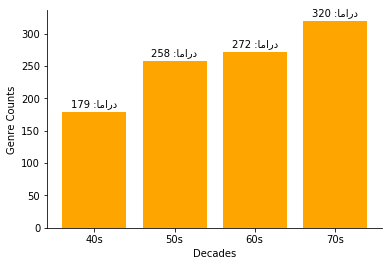

In [443]:
plot_genre_dominations(movies_40s, movies_50s,\
                                   movies_60s, movies_70s)

### Which movie genres had the least existence per decade?

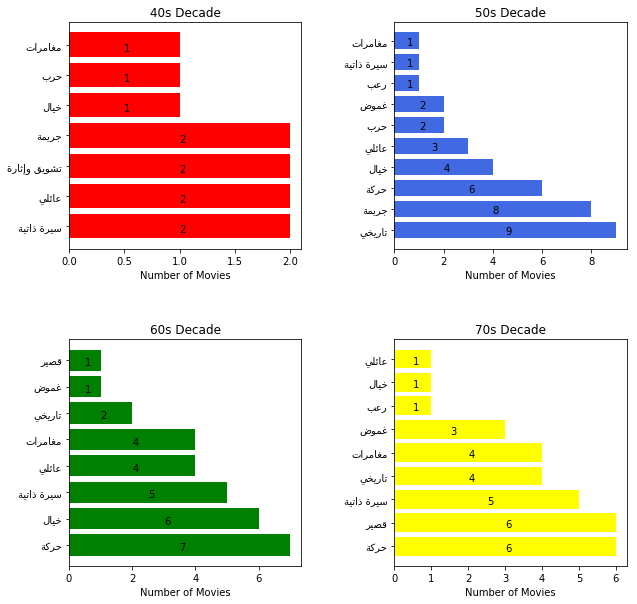

In [445]:
genre_count_40s, genre_count_50s, genre_count_60s, genre_count_70s =\
            get_genres_counts(movies_40s, movies_50s,\
                                   movies_60s, movies_70s)
plot_least_existing_genres(genre_count_40s, genre_count_50s,\
                           genre_count_60s, genre_count_70s)

### Which is the highest rated film in each  decade?

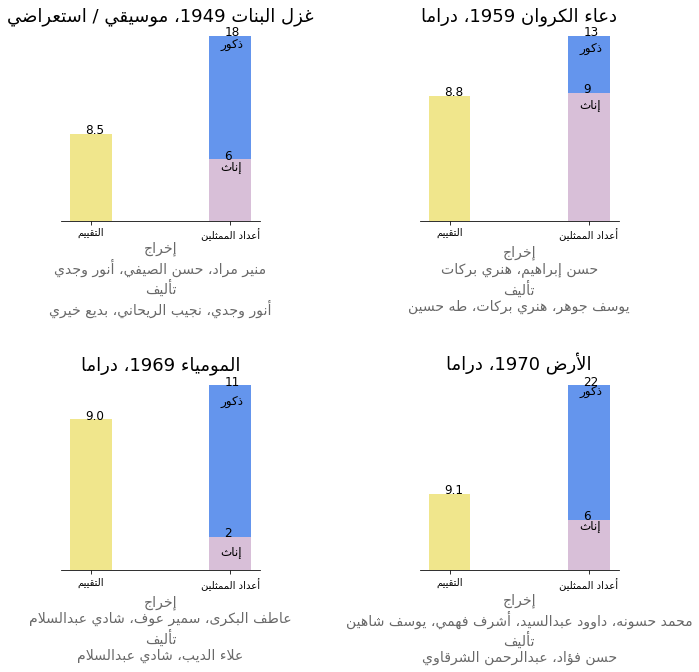

In [446]:
highest_rated_40s, highest_rated_50s,\
    highest_rated_60s, highest_rated_70s \
        = get_highest_rates(movies_40s, movies_50s,\
                                   movies_60s, movies_70s)

plot_highest_rates(highest_rated_40s, highest_rated_50s,\
    highest_rated_60s, highest_rated_70s)

### Has the number of actresses increased over the decades?

Text(0.5, 1.0, 'Increase in Male and Female Presence in Movies')

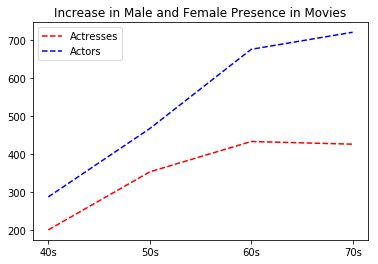

In [447]:
count_actors = get_actors_count(movies_40s, movies_50s,\
                                   movies_60s, movies_70s)
count_actresses = get_actresses_count(movies_40s, movies_50s,\
                                   movies_60s, movies_70s)
figure, axis = plt.subplots()
axis.plot(decades, count_actresses, 'r--', label ='Actresses')
axis.plot(decades, count_actors, 'b--', label = 'Actors')
axis.legend()
axis.set_title('Increase in Male and Female Presence in Movies')

### Which director(s) directed the most movies per decade?

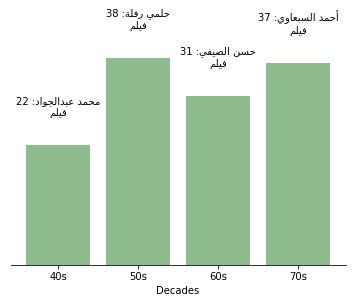

In [448]:
top_directors, top_directors_counts = get_top_directors(movies_40s,\
                                                        movies_50s,\
                                                        movies_60s,\
                                                        movies_70s)
plot_top_directors(top_directors, top_directors_counts)

### What is the average duration of a movie with respect to each genre?

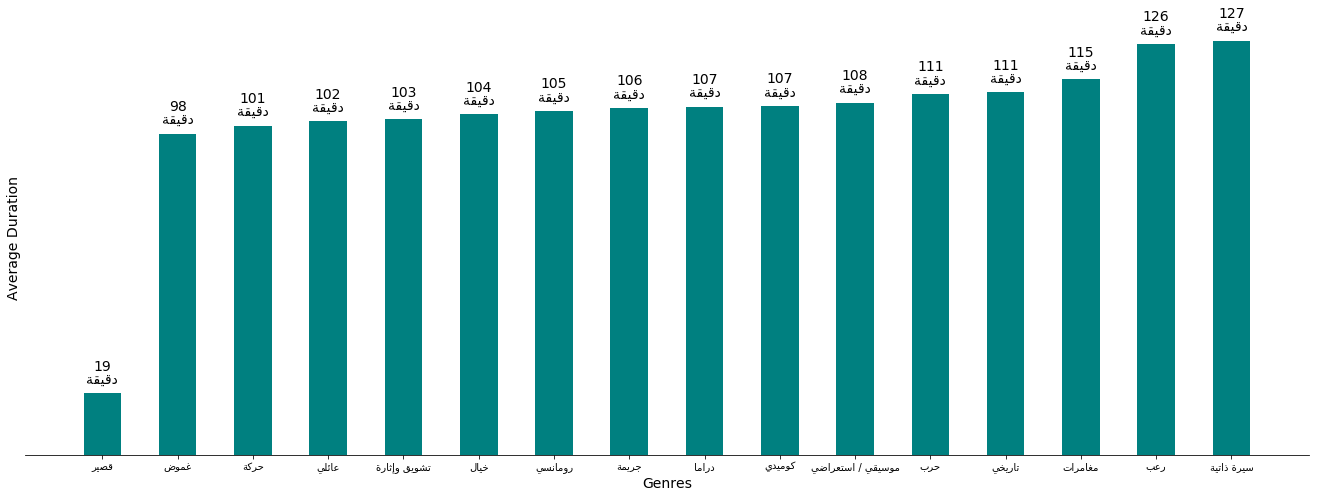

In [449]:
average_duration_per_genre(movies_df)